### Note
- Pre-trained 모델이 아닌 fully training이 가능한 medium 사이즈의 이미지 모델 활용

### 목적
- 이후 텍스트도 Transformers 인코더만 활용할 수 있을지 확인
- fully training도 충분하게 학습할 수 있을지 확인

In [32]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sat Jun 22 08:25:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   49C    P0              28W /  72W |   2434MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 0. 라이브러리

In [33]:
import os

# OS 충돌 방지
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Matplotlib 커널 종료 방지
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [34]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import random
import zipfile
import copy
import glob
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

from torchvision import transforms

import transformers
from transformers import AutoTokenizer, AutoModel, ViTFeatureExtractor, ViTModel, get_linear_schedule_with_warmup

from peft import get_peft_model, LoraConfig, TaskType

In [35]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 42
fixSEED(seed=seed)

In [36]:
# 디렉토리 설정
dir = 'Python_Programs'
path = '/home/leesanghyuk2000/' + dir
os.chdir(path)
print('Current path: {}'.format(os.getcwd()))

Current path: /home/leesanghyuk2000/Python_Programs


In [37]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1. 데이터 불러오기

In [38]:
# 데이터 불러오기
with open('youtubeData(8331)_with_label.pkl', 'rb') as f:
    data = pickle.load(f)

In [40]:
# 썸네일 이미지가 없는 데이터 있는지 확인
data[data['saved'] == 0]

,youtuber,my_label,channel_id,title,video_id,thumbnail,content,saved,label


In [41]:
# 열 생성
data['drive_saved'] = 0

# 썸네일 파일 경로
thumbnail_path = 'Thumbnails/Thumbnails'

# 각 video_id에 대해 파일 존재 여부 확인
for i in tqdm(data.index, desc="Checking thumbnails"):
    video_id = data.at[i, 'video_id']
    file_path = os.path.join(thumbnail_path, f"{video_id}.jpg")
    if os.path.isfile(file_path):
        data.at[i, 'drive_saved'] = 1

Checking thumbnails: 100%|██████████| 8331/8331 [00:00<00:00, 17455.59it/s]


In [42]:
data['drive_saved'].value_counts()

drive_saved
1    8331
Name: count, dtype: int64

In [43]:
# 레이블 개수 확인
data['label'].value_counts()

label
0    5208
1    3123
Name: count, dtype: int64

### 2. Train/Test/Valid

In [44]:
# Split into Train/Valid/Test
def splitData(data, SEED=42):
    train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['label'])
    train_data, valid_data = train_test_split(train_val_data, test_size=0.25, random_state=SEED, stratify = train_val_data['label'])

    print('학습용 데이터 개수 : {}개 \n검증용 데이터 개수 : {}개 \n평가용 데이터 개수 : {}개'.format(len(train_data), len(valid_data), len(test_data)))
    del train_val_data
    return train_data, valid_data, test_data

In [45]:
train_data, valid_data, test_data = splitData(data)

학습용 데이터 개수 : 4998개 
검증용 데이터 개수 : 1666개 
평가용 데이터 개수 : 1667개


### 3. Dataset 및 DataLoader 정의

In [46]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [47]:
# LeNet+RoBERTa Dataset
class LeNetBERTDataset(Dataset):
    def __init__(self, dataframe, text_tokenizer, max_length, image_path, transform=None):
        self.data = dataframe
        self.text_tokenizer = text_tokenizer
        self.max_length = max_length
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #title = self.data.iloc[idx]['title'] # 제목
        content = self.data.iloc[idx]['content'] # 내용
        #text = title + ' ' + content # 제목 + 내용
        video_id = self.data.iloc[idx]['video_id'] # 영상 ID
        label = self.data.iloc[idx]['label']

        # text 토크나이저
        text_inputs = self.text_tokenizer(content, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        input_ids = text_inputs['input_ids'].squeeze(0)
        attention_mask = text_inputs['attention_mask'].squeeze(0)

        # image 불러오기 및 전처리
        img_path = os.path.join(self.image_path, f"{video_id}.jpg")
        image = Image.open(img_path)
        if self.transform is not None:
            image = self.transform(image)            

        return input_ids, attention_mask, image, torch.tensor(label, dtype=torch.long)  # 정수형

### 4. 모델 정의

In [48]:
class LeNet(nn.Module):
    def __init__(self, output_dim=768):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7)) # 고정된 크기의 출력, Linear를 사용하면 이미지 크기에 따라 바뀜
        self.fc1 = nn.Linear(32 * 7 * 7, output_dim) # RoBERTa의 출력크기인 768과 맞춰줌
        self.relu3 = nn.ReLU()

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.adaptive_pool(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc1(out)
        out = self.relu3(out)
        return out


In [49]:
class LeNetBERTModel(nn.Module):
    def __init__(self, text_checkpoint, lenet_model, lora_r=4, lora_alpha=1, lora_dropout=0.1):
        super(LeNetBERTModel, self).__init__()

        # Pre-trained model for text
        self.text_model = AutoModel.from_pretrained(text_checkpoint, output_hidden_states=True)
        
        # Use LeNet for image
        self.img_model = lenet_model

        # LoRA Config for text model
        text_config = LoraConfig(
            target_modules=["query", "key", "value"],
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout
        )

        # Apply LoRA to text model
        self.text_model = get_peft_model(self.text_model, text_config)

        # Transformer Encoder for concat outputs
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.text_model.config.hidden_size + 768,  # LeNet 출력은 768
            nhead=8
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)

        # Classifier layer
        self.classifier = nn.Linear(self.text_model.config.hidden_size + 768, 2)

        # Dropout
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_ids, attention_mask, images):
        # Text model forward
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_hidden_state = text_outputs.last_hidden_state[:, 0, :]  # CLS token

        # Image model forward
        img_hidden_state = self.img_model(images)

        # Concat text and image result
        concat_hidden_state = torch.cat((text_hidden_state, img_hidden_state), dim=1).unsqueeze(1)

        # Pass concat result to transformer encoder
        encoded_output = self.transformer_encoder(concat_hidden_state)
        encoded_output = encoded_output[:, 0, :]  # CLS token

        # Apply dropout
        encoded_output = self.dropout(encoded_output)

        # Pass through classifier
        logits = self.classifier(encoded_output)

        return logits


### 5. 학습용 Trainer 정의

In [50]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, precision_metric, recall_metric, f1_metric, device, num_epochs, wait_for_es):
        self.model = model  # model for training
        self.train_dataloader = train_dataloader  # training dataloader
        self.valid_dataloader = valid_dataloader  # validation dataloader
        self.criterion = criterion  # loss function
        self.optimizer = optimizer  # optimizer
        self.acc_metric = acc_metric  # accuracy metric
        self.precision_metric = precision_metric  # precision metric
        self.recall_metric = recall_metric  # recall metric
        self.f1_metric = f1_metric  # f1 score metric
        self.device = device  # device(cuda or cpu)
        self.num_epochs = num_epochs  # number of epochs
        self.wait_for_es = wait_for_es  # early stopping patience
        
        # 스케줄러 초기화
        total_steps = len(train_dataloader) * num_epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    def train(self):
        train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history = [], [], [], [], []
        valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = [], [], [], [], []

        best_loss = float('inf')
        count = 0
        best_acc = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            print('-' * 80)
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print('-' * 80)

            train_loss, train_acc, train_precision, train_recall, train_f1 = self._train_model()
            valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = self._valid_model()

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            train_precision_history.append(train_precision)
            train_recall_history.append(train_recall)
            train_f1_history.append(train_f1)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            valid_precision_history.append(valid_precision)
            valid_recall_history.append(valid_recall)
            valid_f1_history.append(valid_f1)

            elapsed_time = time.time() - start_time
            print(f'[Train] \t Loss: {train_loss:.4f} \t Acc: {train_acc:.4f} \t Precision: {train_precision:.4f} \t Recall: {train_recall:.4f} \t F1: {train_f1:.4f}')
            print(f'[Valid] \t Loss: {valid_loss:.4f} \t Acc: {valid_acc:.4f} \t Precision: {valid_precision:.4f} \t Recall: {valid_recall:.4f} \t F1: {valid_f1:.4f}')
            print(f'(Epoch {epoch+1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s)')

            if valid_acc > best_acc:
                best_acc = valid_acc
                try:
                    save_path = f'./YouTube_RoBERTa_LeNet_ACC_{valid_acc:.4f}.pth'
                    torch.save(self.model.state_dict(), save_path)
                    print(f'Model Saved to {save_path}')
                except:
                    print('Model Not Saved')
                    continue

            if valid_loss < best_loss:
                best_loss = valid_loss
                count = 0
            else:
                count += 1
                if count >= self.wait_for_es:
                    print(f'Early Stopping at Epoch {epoch+1}')
                    break

        return train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history

    # Training function
    def _train_model(self):
        self.model.train()

        train_loss = 0
        train_acc = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0

        for batch in tqdm(self.train_dataloader, desc='Training'):
            input_ids, attention_mask, images, y = batch
            input_ids, attention_mask, images, y = input_ids.to(self.device), attention_mask.to(self.device), images.to(self.device), y.to(self.device)

            outputs = self.model(input_ids, attention_mask, images)
            loss = self.criterion(outputs, y) # 데이터셋에서 레이블을 long으로 정의함

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()  # 스케줄러 업데이트

            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += self.acc_metric(preds, y).item()
            train_precision += self.precision_metric(preds, y).item()
            train_recall += self.recall_metric(preds, y).item()
            train_f1 += self.f1_metric(preds, y).item()

        return train_loss / len(self.train_dataloader), train_acc / len(self.train_dataloader), train_precision / len(self.train_dataloader), train_recall / len(self.train_dataloader), train_f1 / len(self.train_dataloader)

    # Validating function
    def _valid_model(self):
        self.model.eval()

        valid_loss = 0
        valid_acc = 0
        valid_precision = 0
        valid_recall = 0
        valid_f1 = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_dataloader, desc='Validating'):
                input_ids, attention_mask, images, y = batch
                input_ids, attention_mask, images, y = input_ids.to(self.device), attention_mask.to(self.device), images.to(self.device), y.to(self.device)

                outputs = self.model(input_ids, attention_mask, images)
                loss = self.criterion(outputs, y)

                preds = torch.argmax(outputs, dim=1)
                valid_loss += loss.item()
                valid_acc += self.acc_metric(preds, y).item()
                valid_precision += self.precision_metric(preds, y).item()
                valid_recall += self.recall_metric(preds, y).item()
                valid_f1 += self.f1_metric(preds, y).item()

        return valid_loss / len(self.valid_dataloader), valid_acc / len(self.valid_dataloader), valid_precision / len(self.valid_dataloader), valid_recall / len(self.valid_dataloader), valid_f1 / len(self.valid_dataloader)


### 6. 학습 설정

In [51]:
# 데이터셋 파라미터
batch_size = 32
num_labels = 2
max_length = 64

# text 토크나이저 정의
text_checkpoint = "klue/roberta-small"
tokenizer = AutoTokenizer.from_pretrained(text_checkpoint)

# image 경로
image_path = 'Thumbnails/Thumbnails'

In [52]:
# 이미지 전처리 객체
transform = transforms.Compose(
    [
        transforms.Resize([256, 256]), # 이미지를 크기를 조정
        #transforms.RandomCrop([224, 224]), # 이미지를 랜덤하게 자르기
        #transforms.RandomResizedCrop(256), # 이미지를 랜덤한 크기로 자르고 크기를 조정
        transforms.RandomHorizontalFlip(), # 이미지를 랜덤하게 수평으로 뒤집기
        transforms.RandomVerticalFlip(), # 이미지를 랜덤하게 수직으로 뒤집기
        #transforms.RandomRotation(45), # 이미지를 랜덤하게 회전
        transforms.ToTensor(), # 이미지를 텐서로 변환
        #transforms.Grayscale(num_output_channels=1), # 이미지를 흑백으로 변환
        #transforms.Normalize((0.5,), (0.5,)), # 이미지를 정규화(ToTensor 다음에 사용)
        #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1) # 이미지의 밝기, 대비, 채도, 색상을 무작위로 조정
])

In [53]:
# 데이터셋 정의
train_dataset = LeNetBERTDataset(train_data, tokenizer, max_length, image_path, transform)
valid_dataset = LeNetBERTDataset(valid_data, tokenizer, max_length, image_path, transform)
test_dataset = LeNetBERTDataset(test_data, tokenizer, max_length, image_path, transform)

In [54]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[    0, 17240,  2052,  ...,  1415,  4000,     2],
         [    0,  4988,  5891,  ...,  2145,  6667,     2],
         [    0,  3909,  2016,  ...,  2259,  3706,     2],
         ...,
         [    0,  5443, 30692,  ...,  2062,  5326,     2],
         [    0, 16465,  2747,  ..., 15154,  2219,     2],
         [    0,   752,  3851,  ...,  1292,  2052,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([[[[0.0235, 0.0235, 0.0235,  ..., 0.0549, 0.0549, 0.0549],
           [0.0235, 0.0235, 0.0235,  ..., 0.0549, 0.0549, 0.0549],
           [0.0235, 0.0235, 0.0235,  ..., 0.0549, 0.0549, 0.0549],
           ...,
           [0.0235, 0.0235, 0.0235,  ..., 0.0902, 0.0980, 0.1059],
           [0.0235, 0.0235, 0.0235,  ..., 0.0941, 0.0824, 0.0745],
           [0.0235, 0.0235, 0.0235,  ..., 0.0667, 0.0

### 7. 학습 설정

In [55]:
# LeNet 모델 설정
lenet_model = LeNet()
lenet_model

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc1): Linear(in_features=1568, out_features=768, bias=True)
  (relu3): ReLU()
)

In [56]:
# Model
model = LeNetBERTModel(text_checkpoint, lenet_model)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LeNetBERTModel(
  (text_model): PeftModel(
    (base_model): LoraModel(
      (model): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(32000, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-5): 6 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Line

In [57]:
# LoRA 적용 후 훈련 가능한 파라미터 개수
print_trainable_parameters(model)

Trainable Params: 32821730 
All params: 100912610
--------------------------------------------------
Trainable(%): 32.5249


In [58]:
# 손실함수와 옵티마이저, 그리고 Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)

In [59]:
# 학습 시작 전 GPU 메모리 확인
def checkGPU(empty=False):
    if torch.cuda.is_available():
        total_mem = torch.cuda.get_device_properties(0).total_memory
        current_mem = torch.cuda.memory_allocated(0)
        free_mem = total_mem - current_mem
        
        print(f'남은 GPU 메모리: {free_mem / (1024 ** 3):.2f} GB')
        
        if empty:
            torch.cuda.empty_cache()
            after_mem = torch.cuda.memory_allocated(0)
            print(f'GPU 캐시에서 메모리 삭제 후 메모리: {after_mem / (1024 ** 3):.2f} GB')
    else:
        print('CUDA 사용 불가')

checkGPU()

남은 GPU 메모리: 20.98 GB


In [60]:
# 모델 학습 파라미터
num_epochs = 10
wait_for_es = 5

In [61]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  precision_metric,
                  recall_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [62]:
# 학습 시작
train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = trainer.train()

--------------------------------------------------------------------------------
Epoch 1/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s]


[Train] 	 Loss: 0.3870 	 Acc: 0.8294 	 Precision: 0.8068 	 Recall: 0.7025 	 F1: 0.7272
[Valid] 	 Loss: 0.1892 	 Acc: 0.9369 	 Precision: 0.9375 	 Recall: 0.8916 	 F1: 0.9099
(Epoch 1 complete in 1m 23s)
Model Saved to ./YouTube_RoBERTa_LeNet_ACC_0.9369.pth
--------------------------------------------------------------------------------
Epoch 2/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:18<00:00,  2.90it/s]


[Train] 	 Loss: 0.1949 	 Acc: 0.9270 	 Precision: 0.9222 	 Recall: 0.8805 	 F1: 0.8936
[Valid] 	 Loss: 0.1572 	 Acc: 0.9393 	 Precision: 0.9687 	 Recall: 0.8669 	 F1: 0.9102
(Epoch 2 complete in 2m 49s)
Model Saved to ./YouTube_RoBERTa_LeNet_ACC_0.9393.pth
--------------------------------------------------------------------------------
Epoch 3/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:18<00:00,  2.93it/s]


[Train] 	 Loss: 0.1592 	 Acc: 0.9411 	 Precision: 0.9408 	 Recall: 0.9061 	 F1: 0.9181
[Valid] 	 Loss: 0.1573 	 Acc: 0.9416 	 Precision: 0.8720 	 Recall: 0.9441 	 F1: 0.9024
(Epoch 3 complete in 4m 14s)
Model Saved to ./YouTube_RoBERTa_LeNet_ACC_0.9416.pth
--------------------------------------------------------------------------------
Epoch 4/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:18<00:00,  2.93it/s]


[Train] 	 Loss: 0.1448 	 Acc: 0.9423 	 Precision: 0.9395 	 Recall: 0.9065 	 F1: 0.9176
[Valid] 	 Loss: 0.1165 	 Acc: 0.9629 	 Precision: 0.9541 	 Recall: 0.9466 	 F1: 0.9476
(Epoch 4 complete in 5m 39s)
Model Saved to ./YouTube_RoBERTa_LeNet_ACC_0.9629.pth
--------------------------------------------------------------------------------
Epoch 5/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:18<00:00,  2.92it/s]


[Train] 	 Loss: 0.1315 	 Acc: 0.9510 	 Precision: 0.9541 	 Recall: 0.9160 	 F1: 0.9293
[Valid] 	 Loss: 0.1368 	 Acc: 0.9487 	 Precision: 0.9659 	 Recall: 0.8556 	 F1: 0.9041
(Epoch 5 complete in 7m 4s)
--------------------------------------------------------------------------------
Epoch 6/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:18<00:00,  2.90it/s]


[Train] 	 Loss: 0.1118 	 Acc: 0.9581 	 Precision: 0.9593 	 Recall: 0.9291 	 F1: 0.9416
[Valid] 	 Loss: 0.1175 	 Acc: 0.9552 	 Precision: 0.9765 	 Recall: 0.8988 	 F1: 0.9338
(Epoch 6 complete in 8m 28s)
--------------------------------------------------------------------------------
Epoch 7/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]


[Train] 	 Loss: 0.1145 	 Acc: 0.9576 	 Precision: 0.9569 	 Recall: 0.9288 	 F1: 0.9390
[Valid] 	 Loss: 0.1118 	 Acc: 0.9611 	 Precision: 0.9767 	 Recall: 0.9141 	 F1: 0.9429
(Epoch 7 complete in 9m 54s)
--------------------------------------------------------------------------------
Epoch 8/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:18<00:00,  2.86it/s]


[Train] 	 Loss: 0.1021 	 Acc: 0.9616 	 Precision: 0.9651 	 Recall: 0.9327 	 F1: 0.9462
[Valid] 	 Loss: 0.1049 	 Acc: 0.9652 	 Precision: 0.9558 	 Recall: 0.9137 	 F1: 0.9319
(Epoch 8 complete in 11m 20s)
Model Saved to ./YouTube_RoBERTa_LeNet_ACC_0.9652.pth
--------------------------------------------------------------------------------
Epoch 9/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:18<00:00,  2.90it/s]


[Train] 	 Loss: 0.0972 	 Acc: 0.9646 	 Precision: 0.9651 	 Recall: 0.9415 	 F1: 0.9508
[Valid] 	 Loss: 0.1033 	 Acc: 0.9640 	 Precision: 0.9711 	 Recall: 0.9319 	 F1: 0.9485
(Epoch 9 complete in 12m 45s)
--------------------------------------------------------------------------------
Epoch 10/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:18<00:00,  2.93it/s]


[Train] 	 Loss: 0.0960 	 Acc: 0.9664 	 Precision: 0.9692 	 Recall: 0.9362 	 F1: 0.9504
[Valid] 	 Loss: 0.1017 	 Acc: 0.9676 	 Precision: 0.9647 	 Recall: 0.9404 	 F1: 0.9497
(Epoch 10 complete in 14m 9s)
Model Saved to ./YouTube_RoBERTa_LeNet_ACC_0.9676.pth


In [64]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history):
    plt.figure(figsize=(16, 9))

    # Loss Plot
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
    ax1.plot(train_loss_history, label='Train Loss')
    ax1.plot(valid_loss_history, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy Plot
    ax2 = plt.subplot2grid((2, 4), (1, 0))
    ax2.plot(train_acc_history, label='Train Accuracy')
    ax2.plot(valid_acc_history, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Precision Plot
    ax3 = plt.subplot2grid((2, 4), (1, 1))
    ax3.plot(train_precision_history, label='Train Precision')
    ax3.plot(valid_precision_history, label='Validation Precision')
    ax3.set_title('Training and Validation Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend()

    # Recall Plot
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax4.plot(train_recall_history, label='Train Recall')
    ax4.plot(valid_recall_history, label='Validation Recall')
    ax4.set_title('Training and Validation Recall')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Recall')
    ax4.legend()

    # F1 Plot
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    ax5.plot(train_f1_history, label='Train F1 Score')
    ax5.plot(valid_f1_history, label='Validation F1 Score')
    ax5.set_title('Training and Validation F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend()

    plt.tight_layout()
    plt.show()

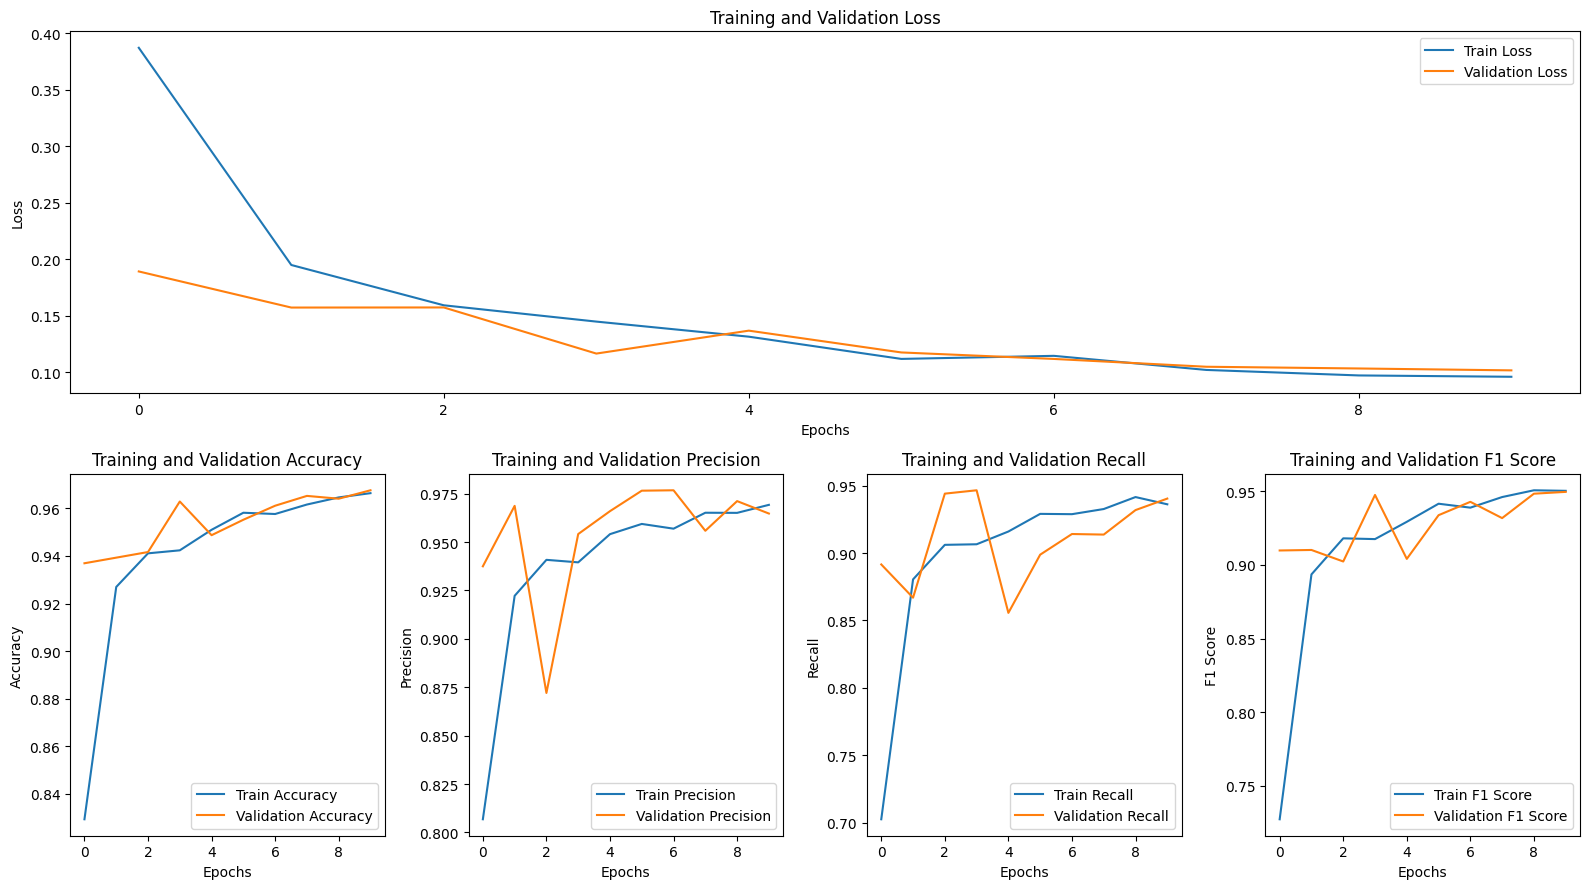

In [65]:
plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history)

### 8. 평가

In [66]:
# 모델 로드 함수 정의
def load_model(model_path, text_checkpoint, lenet_model):
    model = LeNetBERTModel(text_checkpoint, lenet_model)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

# Inference 함수 정의
def inference(model, test_dataloader, device):
    model.eval()

    preds_list = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Testing'):
            input_ids, attention_mask, images, labels = batch
            input_ids, attention_mask, images, labels = input_ids.to(device), attention_mask.to(device), images.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask, images)
            preds = torch.argmax(outputs, dim=1)

            preds_list.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return preds_list, true_labels

In [67]:
# 저장된 모델 경로
best_model_path = path+'/YouTube_RoBERTa_LeNet_ACC_0.9676.pth'

In [68]:
# 모델 불러오기
model = load_model(best_model_path, text_checkpoint, lenet_model)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
preds_list, true_labels = inference(model, test_dataloader, device)

Testing: 100%|██████████| 53/53 [00:20<00:00,  2.62it/s]


In [70]:
# 평가 지표 계산
test_accuracy = accuracy_score(true_labels, preds_list)
test_precision = precision_score(true_labels, preds_list)
test_recall = recall_score(true_labels, preds_list)
test_f1 = f1_score(true_labels, preds_list)
test_cm = confusion_matrix(true_labels, preds_list)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Confusion Matrix: \n{test_cm}')

Test Accuracy: 0.9718
Test Precision: 0.9707
Test Recall: 0.9536
Test F1 Score: 0.9621
Test Confusion Matrix: 
[[1024   18]
 [  29  596]]
